In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_7131.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_8237.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_9862.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_8315.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_251.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_4534.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_63.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_11206.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_8224.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_11959.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_19677.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_825.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_12541.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_9409.JPEG
/kaggle/input/imagenet10/imagenet-10/n02056570/n02056570_61.JP

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary
from tqdm.auto import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class ResNetBlock(nn.Module):
    multi = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.i_downsample = i_downsample
        
    def forward(self, x):
        res_x = x.clone()
        if self.i_downsample is not None:
            res_x = self.i_downsample(res_x)
            
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        return self.relu2(res_x + x)  

res_model = ResNetBlock(64, 64).to(device)
dummy = torch.randn(1, 64, 112, 112).to(device)

summary(res_model, input_size=(1, 64, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetBlock                              [1, 64, 112, 112]         --
├─Conv2d: 1-1                            [1, 64, 112, 112]         36,864
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─Conv2d: 1-4                            [1, 64, 112, 112]         36,864
├─BatchNorm2d: 1-5                       [1, 64, 112, 112]         128
├─ReLU: 1-6                              [1, 64, 112, 112]         --
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
Total mult-adds (M): 924.84
Input size (MB): 3.21
Forward/backward pass size (MB): 25.69
Params size (MB): 0.30
Estimated Total Size (MB): 29.20

In [6]:
class BottleNeck(nn.Module):
    multi = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.multi, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.multi)
        self.relu3 = nn.ReLU(inplace=True)
        self.i_downsample = i_downsample
        
    def forward(self, x):
        res_x = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        if self.i_downsample is not None:
            res_x = self.i_downsample(res_x)
            
        x = self.conv3(x)
        x = self.bn3(x)
        x = x + res_x
        x = self.relu3(x)
        
        return x
    
bottleneck_model = BottleNeck(256, 64).to(device)
dummy = torch.randn(1, 256, 112, 112).to(device)
summary(bottleneck_model, input_size=(1, 256, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
BottleNeck                               [1, 256, 112, 112]        --
├─Conv2d: 1-1                            [1, 64, 112, 112]         16,384
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─Conv2d: 1-4                            [1, 64, 112, 112]         36,864
├─BatchNorm2d: 1-5                       [1, 64, 112, 112]         128
├─ReLU: 1-6                              [1, 64, 112, 112]         --
├─Conv2d: 1-7                            [1, 256, 112, 112]        16,384
├─BatchNorm2d: 1-8                       [1, 256, 112, 112]        512
├─ReLU: 1-9                              [1, 256, 112, 112]        --
Total params: 70,400
Trainable params: 70,400
Non-trainable params: 0
Total mult-adds (M): 873.46
Input size (MB): 12.85
Forward/backward pass size (MB): 77.07
Params size (MB): 0.28
Estimated Total Size (MB): 

In [7]:


class ResNet(nn.Module):
    def __init__(self, ResNetBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(ResNetBlock, layer_list[0], planes=64)
        self.layer2 = self.make_layer(ResNetBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self.make_layer(ResNetBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self.make_layer(ResNetBlock, layer_list[3], planes=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResNetBlock.multi, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def make_layer(self, ResNetBlock, blocks, planes, stride=1):
        ii_downsample = None
        layer_list = []
        
        if stride != 1 or self.in_channels != planes*ResNetBlock.multi:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResNetBlock.multi, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*ResNetBlock.multi)
            )
            
        layer_list.append(ResNetBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResNetBlock.multi
        
        for i in range(blocks-1):
            layer_list.append(ResNetBlock(self.in_channels, planes))
            
        return nn.Sequential(*layer_list)



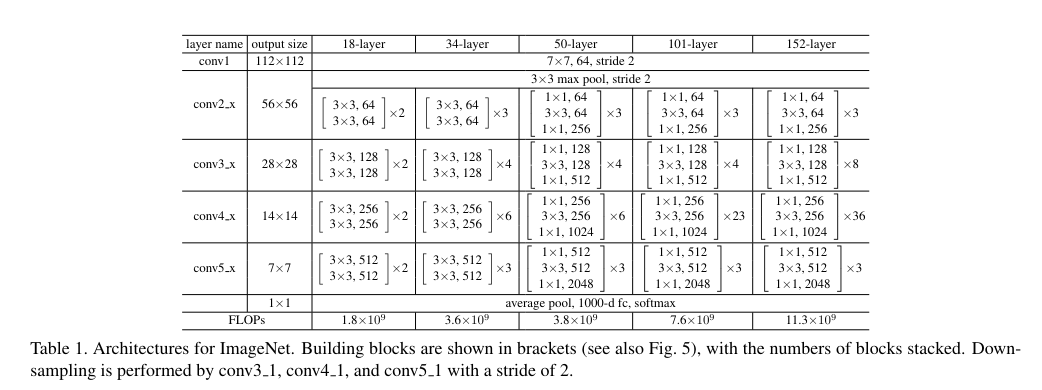

In [8]:
def ResNet18(num_classes, in_channels=3):
    return ResNet(ResNetBlock, [2,2,2,2], num_classes, num_channels=in_channels)

resnet18 = ResNet18(10, 3).to(device)
input_shape = (1, 3, 244, 244)
summary(resnet18, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─ResNetBlock: 2-1                  [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [9]:
from torchvision.models import resnet18

# Comparing with torchvision resnet18
resnet18_model = resnet18(num_classes=10).to(device)
dummy = torch.randn(1, 3, 224, 224).to(device)
summary(resnet18_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [10]:
def ResNet34(num_classes, in_channels=3):
    return ResNet(ResNetBlock, [3,4,6,3], num_classes, num_channels=in_channels)

def ResNet50(num_classes, in_channels=3):
    return ResNet(BottleNeck, [3,4,6,3], num_classes, num_channels = in_channels)

def ResNet101(num_classes, in_channels=3):
    return ResNet(BottleNeck, [3,4,23,3], num_classes, num_channels = in_channels)

def ResNet134(num_classes, in_channels=3):
    return ResNet(BottleNeck, [3,8,36,3], num_classes, num_channels = in_channels)


In [11]:
# Dataset and Dataloader
data_dir = '/kaggle/input/imagenet10/imagenet-10'

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split to train and valid
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

model = ResNet34(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch} [Training]', leave=False)
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix({
            'Loss': running_loss / total,
            'Accuracy': correct / total
        })

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    
def validate(model, val_loader, criterion, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch} [Validation]', leave=False)
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_loader_tqdm.set_postfix({
                'Loss': running_loss / total,
                'Accuracy': correct / total
            })

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / len(val_loader.dataset)
    print(f'Epoch {epoch}, Validation loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    


In [12]:
num_epochs = 10

import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, criterion, optimizer, epoch)
    validate(model, val_loader, criterion, epoch)


Epoch 1 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 1, Training loss: 1.8585, Accuracy: 0.3392


Epoch 1 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 1, Validation loss: 1.6320, Accuracy: 0.4062


Epoch 2 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 2, Training loss: 1.5135, Accuracy: 0.4562


Epoch 2 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 2, Validation loss: 1.8833, Accuracy: 0.4042


Epoch 3 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 3, Training loss: 1.3672, Accuracy: 0.5229


Epoch 3 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 3, Validation loss: 2.0885, Accuracy: 0.4500


Epoch 4 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 4, Training loss: 1.2522, Accuracy: 0.5683


Epoch 4 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 4, Validation loss: 1.2496, Accuracy: 0.5838


Epoch 5 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 5, Training loss: 1.1184, Accuracy: 0.6213


Epoch 5 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 5, Validation loss: 1.0761, Accuracy: 0.6350


Epoch 6 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 6, Training loss: 1.0274, Accuracy: 0.6532


Epoch 6 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 6, Validation loss: 1.1251, Accuracy: 0.6292


Epoch 7 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 7, Training loss: 0.9906, Accuracy: 0.6704


Epoch 7 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 7, Validation loss: 1.1133, Accuracy: 0.6365


Epoch 8 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 8, Training loss: 0.9264, Accuracy: 0.6926


Epoch 8 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 8, Validation loss: 0.9812, Accuracy: 0.6858


Epoch 9 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 9, Training loss: 0.8485, Accuracy: 0.7181


Epoch 9 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 9, Validation loss: 0.9552, Accuracy: 0.6765


Epoch 10 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 10, Training loss: 0.8034, Accuracy: 0.7359


Epoch 10 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 10, Validation loss: 0.7827, Accuracy: 0.7408


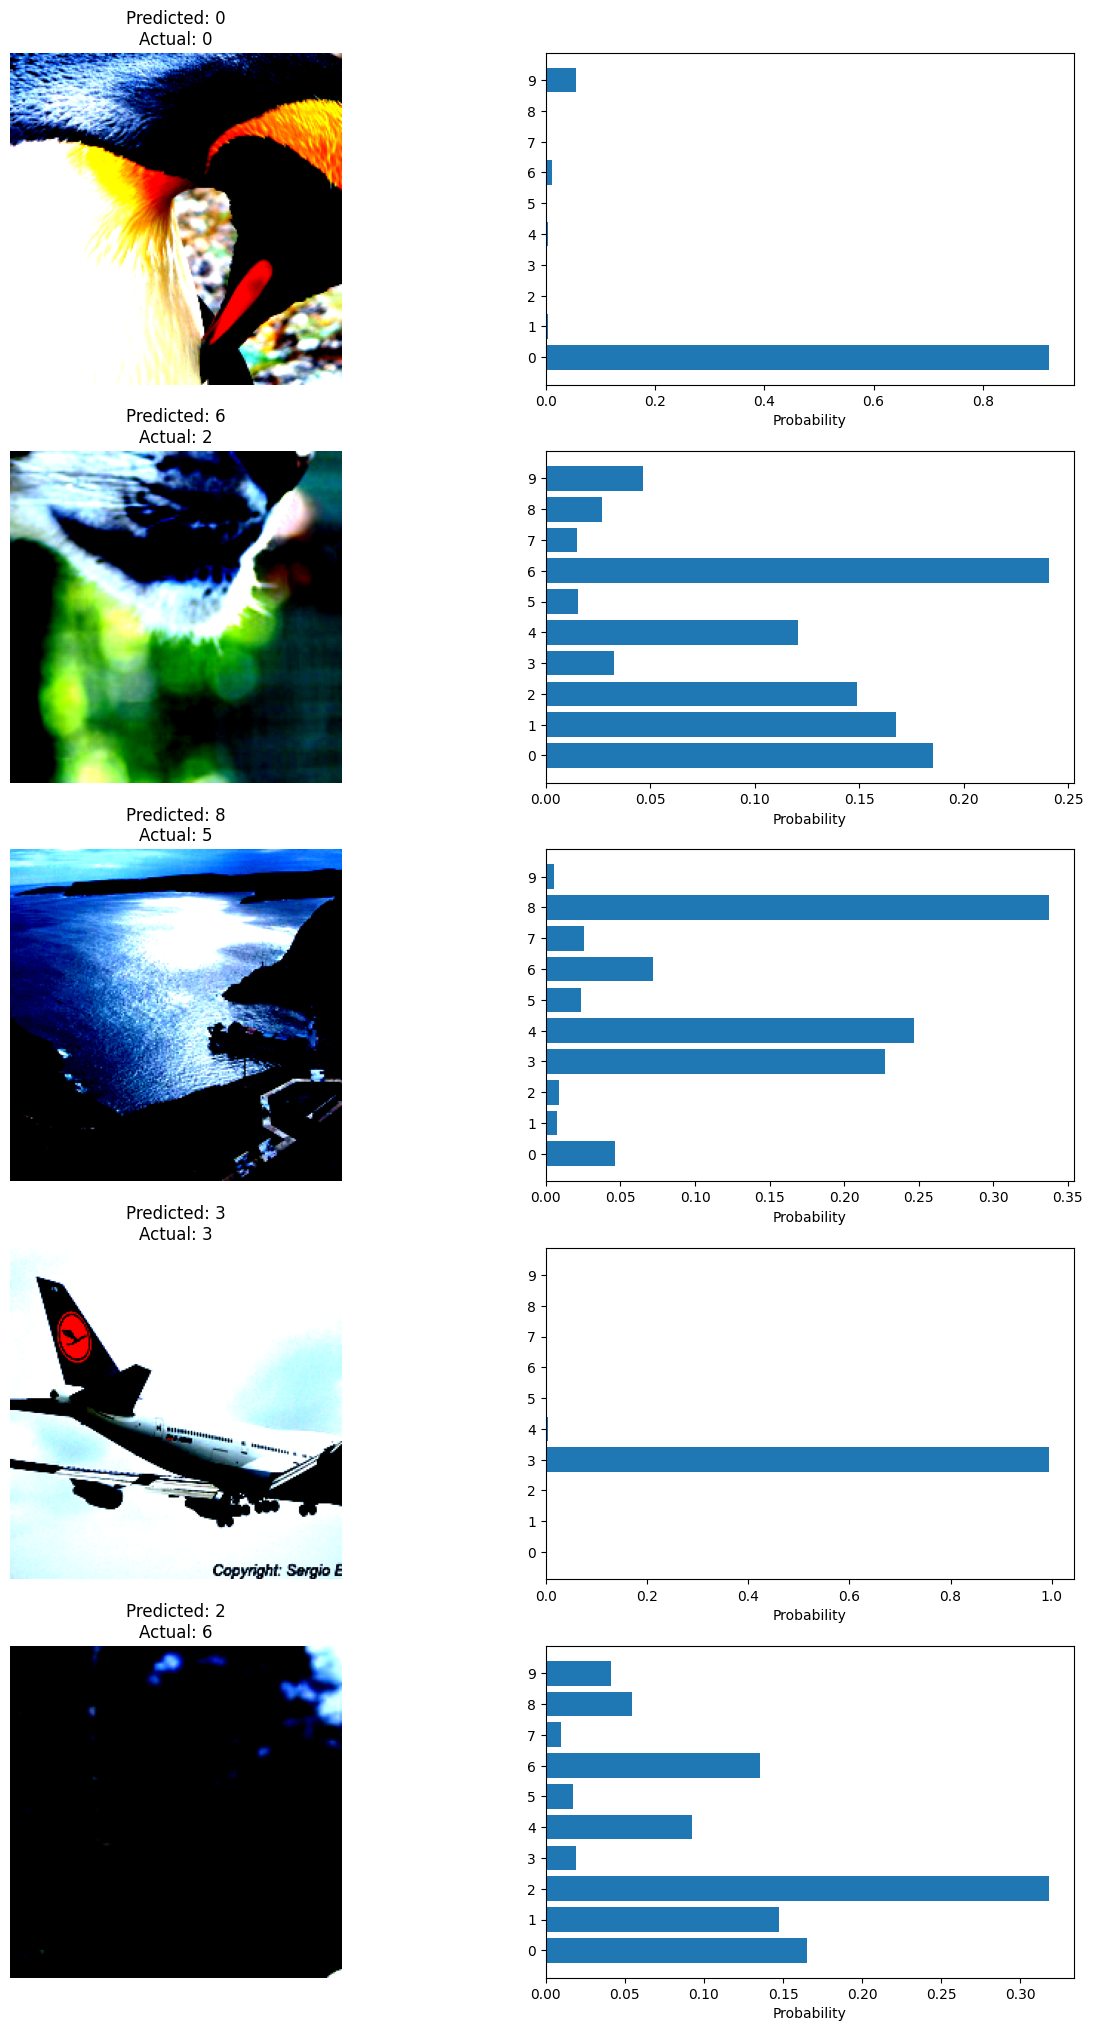

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# Define a function to visualize the predictions
def visualize_predictions(model, loader, device, class_names, num_images=5):
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(15, num_images * 5))

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                images_so_far += 1
                if images_so_far > num_images:
                    return
                
                plt.subplot(num_images, 2, 2 * images_so_far - 1)
                plt.imshow(images.cpu().data[j].permute(1, 2, 0).numpy())
                plt.title(f'Predicted: {preds[j]}\nActual: {labels[j]}')
                plt.axis('off')

                plt.subplot(num_images, 2, 2 * images_so_far)
                probabilities = torch.nn.functional.softmax(outputs[j], dim=0)
                plt.barh(range(len(class_names)), probabilities.cpu().numpy())
                plt.yticks(range(len(class_names)), range(len(class_names)))  # Use class index values
                plt.xlabel('Probability')

# Assuming class_names is a list of class names corresponding to the dataset
class_names = dataset.classes

# Visualize predictions on validation set
visualize_predictions(model, val_loader, device, class_names, num_images=5)